In [2]:
import sys

import importlib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sqlalchemy
import gensim
import logging

import common
import util
importlib.reload(common)
importlib.reload(util)

from common import create_engine
from common import display_all
from common import figsize
from common import save_df, load_df
from common import save_session, load_session

from util import show_importances
from util import split_X_y_all, split_X_y, split_data
from util import empty_features, column_feature, str_contains

from pbar import Pbar

from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters() # converters e.g. for datetime in plots
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [3]:
engine = create_engine('db-conf.json', 'local')
pd.sql = lambda sql: pd.read_sql(sqlalchemy.text(sql), con=engine)

Vytvorenie materialized views kvoli obmedzeniu datovej mnoziny

In [4]:
REFRESH_MVIEWS = True

In [6]:
mviews_queries = [
    # iba clanky z monitorov v kategoriach 'english' a 'medical' + publikovane po 'zaciatok-monitoringu' - 4 dni
    '''
    DROP MATERIALIZED VIEW IF EXISTS new_articles CASCADE;
    CREATE MATERIALIZED VIEW new_articles AS (
    SELECT *
    FROM article
    WHERE monitor_id in (1, 4, 5, 7, 8, 9, 10)
      AND published_at >= '2019-10-10 00:00:00.000000');
    ''',
    
    # maximalne id pozorovania pre danu kombinaciu (url, datum)
    '''
    DROP MATERIALIZED VIEW IF EXISTS article_fb_engagement_per_day CASCADE;
    CREATE MATERIALIZED VIEW article_fb_engagement_per_day AS (
    SELECT max(id) last_id_on_day, related_object_url as url, extracted_at::date as sync_on_day
    FROM feedback_facebook
    GROUP BY url, sync_on_day);
    ''',
    
    # fb popularita + url + rozdiel medzi datumom publikovania a datumom ziskania dat z FB
    '''
    DROP MATERIALIZED VIEW IF EXISTS new_articles_fb_engagement CASCADE;
    CREATE MATERIALIZED VIEW new_articles_fb_engagement AS (
    SELECT fb.id,
           fb.related_object_url                     as url,
           fb.reaction_count,
           fb.comment_count,
           fb.share_count,
           fb.comment_plugin_count,
           afepd.sync_on_day,
           na.published_at,
           afepd.sync_on_day - na.published_at::date as days_after_publication
    FROM article_fb_engagement_per_day afepd
             JOIN feedback_facebook fb ON fb.id = afepd.last_id_on_day
             JOIN new_articles na ON na.url = afepd.url);
    '''
]

if REFRESH_MVIEWS:
    with engine.connect() as connection:
        for q in mviews_queries:
            connection.execute(q)

In [42]:
main_view = '''
CREATE OR REPLACE VIEW main_articles_view AS
SELECT a.id,
       a.url,
       title,
       perex,
       body,
       a.published_at,
       extracted_at,
       category,
       other_info,
       coalesce(imgc.cnt, 0)            as image_count,
       coalesce(vidc.cnt, 0)            as video_count,
       aut.name                         as author_name,
       s.id                             as source_id,
       s.name                           as source_name,
       s.url                            as source_url,
       stype                            as source_type,
       is_reliable::integer             as source_is_reliable,
       av.veracity                      as av_veracity,
       coalesce(claims_false, 0)        as av_claims_false,
       coalesce(claims_mostly_false, 0) as av_claims_mostly_false,
       coalesce(claims_mixture, 0)      as av_claims_mixture,
       coalesce(claims_mostly_true, 0)  as av_claims_mostly_true,
       coalesce(claims_true, 0)         as av_claims_true,
       coalesce(av.claims_unknown, 0)   as av_claims_unknown
FROM new_articles a
         JOIN source s on a.source_id = s.id
         JOIN author aut on a.author_id = aut.id
         LEFT JOIN (SELECT article_id, count(*) as cnt
                    FROM media
                    WHERE media_type = 'image'
                    GROUP BY article_id) imgc ON a.id = imgc.article_id
         LEFT JOIN (SELECT article_id, count(*) as cnt
                    FROM media
                    WHERE media_type = 'video'
                    GROUP BY article_id) vidc ON a.id = vidc.article_id
         LEFT JOIN article_veracity av on a.id = av.article_id
WHERE s.is_reliable IS NOT NULL;
'''
with engine.connect() as connection:
     connection.execute(main_view)

In [43]:
# - obsah clanku (+meta)
# - meno autora
# - pocet obrazkov / videii
# - pocet claimov
# - veracity (podla claimov)
# - zdroj (nazov, url)
# - anotacia doveryhodnosti zdroja

df = pd.sql('SELECT * FROM main_articles_view;')

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20194 entries, 0 to 20193
Data columns (total 24 columns):
id                        20194 non-null int64
url                       20194 non-null object
title                     20194 non-null object
perex                     15639 non-null object
body                      20160 non-null object
published_at              20194 non-null datetime64[ns]
extracted_at              20194 non-null datetime64[ns]
category                  13237 non-null object
other_info                20190 non-null object
image_count               20194 non-null int64
video_count               20194 non-null int64
author_name               20194 non-null object
source_id                 20194 non-null int64
source_name               20194 non-null object
source_url                20194 non-null object
source_type               20194 non-null object
source_is_reliable        20194 non-null int64
av_veracity               4248 non-null object
av_claims_false  

In [45]:
# url, popularita na fb, rozdiel sync - publikovanie (max 30 dni)

DAYS_AFTER_POP_CUTOUT = 15

fb = pd.sql(f'''

SELECT url,
       reaction_count,
       share_count,
       comment_count,
       comment_plugin_count,
       sync_on_day,
       days_after_publication
FROM new_articles_fb_engagement
WHERE days_after_publication BETWEEN 0 AND {DAYS_AFTER_POP_CUTOUT}
AND url in (SELECT url FROM main_articles_view);
''')

In [47]:
assert DAYS_AFTER_POP_CUTOUT >= fb.days_after_publication.max()

In [48]:
fb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245730 entries, 0 to 245729
Data columns (total 7 columns):
url                       245730 non-null object
reaction_count            245730 non-null int64
share_count               245730 non-null int64
comment_count             245730 non-null int64
comment_plugin_count      245730 non-null int64
sync_on_day               245730 non-null object
days_after_publication    245730 non-null int64
dtypes: int64(5), object(2)
memory usage: 13.1+ MB


In [49]:
def append_popularity_columns(df, fb):
    df = df.copy()
    fb = fb.copy()
    
    cols = [
        'url',
        'days_after_publication',
        'reaction_count',
        'share_count',
        'comment_count'
    ] 
    
    fb = fb[cols].pivot_table(index='url',
                         columns='days_after_publication')
    fb.columns = [f'fb_ad_{j}_{i}' for i,j in fb.columns.values]
    
    df = df.query("url in @fb.index")
    df = pd.concat((df.set_index('url'), fb), axis=1, join='inner')
    return df.set_index('id')

In [50]:
def append_fb_pop_sum(df):
    df = df.copy()
    for i in range(0, DAYS_AFTER_POP_CUTOUT + 1):
        cols = [
            f'fb_ad_{i}_comment_count',
            f'fb_ad_{i}_share_count',
            f'fb_ad_{i}_reaction_count'
        ]
        df[f'fb_popularity_ad_{i}'] = df[cols].apply(np.sum, axis=1)
    return df

In [51]:
xdf = append_popularity_columns(df, fb)
xdf = append_fb_pop_sum(xdf)

df = xdf

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18967 entries, 428781 to 809428
Data columns (total 86 columns):
title                      18967 non-null object
perex                      15077 non-null object
body                       18933 non-null object
published_at               18967 non-null datetime64[ns]
extracted_at               18967 non-null datetime64[ns]
category                   12710 non-null object
other_info                 18963 non-null object
image_count                18967 non-null int64
video_count                18967 non-null int64
author_name                18967 non-null object
source_id                  18967 non-null int64
source_name                18967 non-null object
source_url                 18967 non-null object
source_type                18967 non-null object
source_is_reliable         18967 non-null int64
av_veracity                3898 non-null object
av_claims_false            18967 non-null int64
av_claims_mostly_false     18967 non-null 

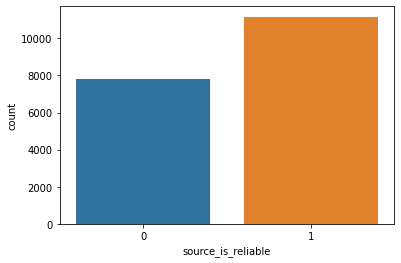

In [54]:
sns.countplot(x='source_is_reliable', data=df)

In [55]:
for i in range(0, DAYS_AFTER_POP_CUTOUT + 1):
    col = f'fb_ad_{i}_share_count' 
    
    nan_cnt = df[col].isna().sum()
    not_nan_cnt = df[col].notna().sum()
    
    print(f'd={i}\ttotal={df[col].size}\tNaN_count = {nan_cnt}\tNotNaN_count = {not_nan_cnt}')

d=0	total=18967	NaN_count = 10365	NotNaN_count = 8602
d=1	total=18967	NaN_count = 5660	NotNaN_count = 13307
d=2	total=18967	NaN_count = 4609	NotNaN_count = 14358
d=3	total=18967	NaN_count = 3858	NotNaN_count = 15109
d=4	total=18967	NaN_count = 3277	NotNaN_count = 15690
d=5	total=18967	NaN_count = 3072	NotNaN_count = 15895
d=6	total=18967	NaN_count = 2819	NotNaN_count = 16148
d=7	total=18967	NaN_count = 2648	NotNaN_count = 16319
d=8	total=18967	NaN_count = 2849	NotNaN_count = 16118
d=9	total=18967	NaN_count = 2735	NotNaN_count = 16232
d=10	total=18967	NaN_count = 2485	NotNaN_count = 16482
d=11	total=18967	NaN_count = 2295	NotNaN_count = 16672
d=12	total=18967	NaN_count = 2401	NotNaN_count = 16566
d=13	total=18967	NaN_count = 2702	NotNaN_count = 16265
d=14	total=18967	NaN_count = 2918	NotNaN_count = 16049
d=15	total=18967	NaN_count = 3033	NotNaN_count = 15934


In [57]:
df.source_name.value_counts()

naturalnews.com                  2716
medicinenet.com                  1886
statnews.com                     1336
nytimes.com                      1225
medicaldaily.com                 1172
latimes.com                      1048
foxnews.com                      1047
themindunleashed.com              989
neurosciencenews.com              983
webmd.com                         818
thenewsdoctors.com                621
healthnutnews.com                 500
healthy-holistic-living.com       469
healthcentral.com                 435
emedicinehealth.com               343
medicalnewstoday.com              298
ageofautism.com                   256
healthimpactnews.com              214
realfarmacy.com                   208
organicfacts.net                  203
consciouslifenews.com             195
hsionline.com                     193
who.int                           187
naturalhealth365.com              186
infowars.com                      180
collective-evolution.com          143
alliancefora

In [58]:
df.source_is_reliable.value_counts()

1    11161
0     7806
Name: source_is_reliable, dtype: int64

### Save final data

In [59]:
save_df(df, 'final_data.pickle')